In [2]:
# Celda de configuración
# Elegir qué métodos ejecutar
CORRER_ECUACIONES_NORMALES = True
CORRER_SVD = True
CORRER_QR = False  # requiere implementar train_qr

# Reducir tamaño del set de entrenamiento para pruebas rápidas
REDUCIR_TAMANIO = True
MAX_COLUMNAS_TRAIN = 250      # se usa si REDUCIR_TAMANIO es True
ALEATORIZAR_MUESTRAS = False   # mezclar antes de recortar columnas

# Semilla para reproducibilidad en el recorte
# Sirve para que, si ALEATORIZAR_MUESTRAS=True, la selección aleatoria de columnas sea siempre la misma (resultados reproducibles).
SEMILLA_REDUCCION = 0


# TP2 - Benchmark de algoritmos

Este notebook:
- Carga los embeddings de `cats_and_dogs` y sus etiquetas (train/val)
- Entrena un clasificador lineal `W` con dos métodos:
  - Ecuaciones Normales (factorización de Cholesky)
  - Pseudo-inversa vía SVD
- Compara tiempos de entrenamiento y accuracy en validación



In [3]:
from pathlib import Path
import time
import numpy as np
import moduloALC as alc

# Gráficos opcionales: si no está matplotlib, seguimos sin gráficos
try:
    import matplotlib.pyplot as plt
    HAY_MPL = True
except Exception:
    HAY_MPL = False

# Directorio del dataset (relativo al repo)
RUTA_DATASET = Path('template-alumnos/dataset/cats_and_dogs')
assert RUTA_DATASET.exists(), f'No se encontró el dataset en {RUTA_DATASET.resolve()}'


In [4]:
# Recarga de módulos de la librería de la cátedra
import importlib
import moduloALC
import moduloALC.LABO3 as _LABO3
import moduloALC.LABO4 as _LABO4
import moduloALC.LABO5 as _LABO5
import moduloALC.LABO6 as _LABO6
import moduloALC.Auxiliares as _Aux

# Recargar submódulos primero
for _m in (_LABO3, _LABO4, _LABO5, _LABO6, _Aux):
    importlib.reload(_m)

# Luego recargar el paquete para refrescar los símbolos reexportados en __init__
importlib.reload(moduloALC)

# Reasignar alias usado en el notebook
alc = moduloALC


In [5]:
def cargarDataset(carpeta: str):
    # Dentro de cats_and_dogs, tenemos train y val, dentro de cada una una carpeta para "cats" y "dogs"
    # cada una de estas, contiene un archivo .npy que es la matriz que queremos
    
    # --- Parte de TRAIN ---
    cats_train = np.load(carpeta + "/train/cats/efficientnet_b3_embeddings.npy")
    dogs_train = np.load(carpeta + "/train/dogs/efficientnet_b3_embeddings.npy")

    Xt = alc.concatenaColumnas(cats_train, dogs_train)   # Unimos los embeddings

    # Para armar Yt necesitamos poner como columnas las etiquetas, esto lo hacemos con un producto matricial:
    # los vectores etiquetas son vectores columna de 2x1: [1,0] para gato o [0,1] para perro
    # multiplicamos el vector etiqueta por otro vector (1,1, ... ,1) de R^n, donde n es el número de columnas de la matriz
    # "cats_train" o "dogs_train". Esto devuelve una matriz de 2xn, que tiene como columnas las etiquetas correspondientes al embedding
    
    nc = cats_train.shape[1]
    nd = dogs_train.shape[1]

    Y_cats = alc.productoMatricial(np.array([[1],[0]]), np.ones((1, nc)))
    Y_dogs = alc.productoMatricial(np.array([[0],[1]]), np.ones((1, nd)))

    Yt = alc.concatenaColumnas(Y_cats, Y_dogs)

    # --- Parte de VALIDATION --- (misma idea)
    cats_val = np.load(carpeta + "/val/cats/efficientnet_b3_embeddings.npy")
    dogs_val = np.load(carpeta + "/val/dogs/efficientnet_b3_embeddings.npy")

    Xv = alc.concatenaColumnas(cats_val, dogs_val)

    nv = cats_val.shape[1]
    mv = dogs_val.shape[1]

    Yv_cats = alc.productoMatricial(np.array([[1],[0]]), np.ones((1, nv)))
    Yv_dogs = alc.productoMatricial(np.array([[0],[1]]), np.ones((1, mv)))

    Yv = alc.concatenaColumnas(Yv_cats, Yv_dogs)

    return Xt, Yt, Xv, Yv


In [6]:
# Resumen:
#   Para resolver el problema min_W ||Y - W X||^2, donde X es la matriz de embeddings y Y la matriz de etiquetas,
#   usamos la pseudoinversa de X, que se define como X+ = (X^t X)^(-1) X^t si n > p o X+ = X^t (X X^t)^(-1) si n < p.
#   Si n = p, X+ = X^(-1). Donde n = dim embeddings, p = número de ejemplos. La solución W es W = Y X+.
#   Vamos a aprovechar la factorización de Cholesky con L triangular para resolver varios sistemas.
#   No es conveniente calcular la inversa directamente ya que toma mucho tiempo y puede ser inestable numéricamente.

def pinvEcuacionesNormales(X, _, Y):
    n = X.shape[0]
    p = X.shape[1]

    if n > p:  # caso n > p
        # Queremos resolver el sistema (X^t X) U = X^t usando la factorización de Cholesky X^t X = L L^t
        # nos queda el sistema L L^t U = X^t. Llamo Z = L^t U
        # primero resolvemos L Z = X^t con sustitución adelante (L es triangular inferior)
        # Cada columna de Z es resultado de resolver L z_i = x_i (x_i es columna de X^t)
        L = alc.calculaCholesky(alc.productoMatricial(alc.traspuesta(X), X))
        Z = resolver_sistema_matricial(L, alc.traspuesta(X))
        # luego resolvemos L^t U = Z con sustitución atrás (L^t es triangular superior) donde U es la pseudoinversa de X
        U = resolver_sistema_matricial(alc.traspuesta(L), Z)
        # Finalmente calculamos W = Y U donde U es la pseudoinversa (WX = Y  -> W = Y @ X+)
        W = alc.productoMatricial(Y, U)
        return W

    if n < p:  # caso n < p
        # Queremos resolver el sistema V (X X^t) = X^t usando la factorización de Cholesky X X^t = L L^t
        # nos queda el sistema V L L^t = X^t. Si transponemos queda L L^t V^t = X^t. Llamo Z = L^t V^t
        # primero resolvemos L Z = X^t con sustitución adelante (L es triangular inferior)
        # Cada columna de Z es resultado de resolver L z_i = x_i (x_i es columna de X^t)
        L = alc.calculaCholesky(alc.productoMatricial(X, alc.traspuesta(X)))
        Z = resolver_sistema_matricial(L, alc.traspuesta(X))
        # luego resolvemos L^t V^t = Z con sustitución atrás (L^t es triangular superior) donde V^t es la pseudoinversa de X transpuesta
        Vt = resolver_sistema_matricial(alc.traspuesta(L), Z)
        U = alc.traspuesta(Vt)   # pseudoinversa de X
        # Finalmente calculamos W = Y U donde U es la pseudoinversa
        W = alc.productoMatricial(Y, U)
        return W

    if n == p:  # caso n = p
        X_inv = alc.inversa(X)
        W = alc.productoMatricial(Y, X_inv)
        return W


In [7]:
def resolver_sistema_matricial(L, B):
    # Crea una matriz Z solución del sistema columna a columna,
    # resolviendo L z_i = b_i en cada paso (L debe ser triangular)
    Z = np.zeros((L.shape[0], B.shape[1]))
    for i in range(B.shape[1]):
        Z[:, i] = alc.res_tri(L, B[:, i])
    return Z


In [8]:
# Resumen:
#   La SVD nos deja descomponer cualquier matriz X como X = U S V^t, donde U y V son ortogonales,
#   o sea su inversa es la traspuesta. La idea es calcular la pseudoinversa de X, que viene a ser X+ = V S+ U^t,
#   donde (V^t)^(-1) = V, U^(-1) = U^t y S+ es la matriz Sigma pero en su diagonal el inverso
#   multiplicativo de los valores singulares.
#   Para este ejercicio seguimos el algoritmo 2 (n < p, rango(X) = n).

def pinvSVD(U, S, V, Y):
    # Construimos S+
    n = S.shape[0]
    S_inv = np.zeros((n, n))
    for i in range(n):
        S_inv[i, i] = 1.0 / S[i]

    # Calculamos la pseudoinversa X+ = V S+ U^t
    X_pinv = alc.productoMatricial(alc.productoMatricial(V, S_inv), alc.traspuesta(U))

    # Calculamos W: WX = Y  -> W = Y @ X+
    W = alc.productoMatricial(Y, X_pinv)
    return W


In [9]:
# Resumen:
#   El objetivo es: dadas dos matrices X y pX (una pseudo-inversa de X), decidir si cumplen
#   las condiciones de Moore-Penrose, con una determinada tolerancia. Para que esto suceda,
#   se deben cumplir las siguientes propiedades:
#       I)   X @ pX @ X = X
#       II)  pX @ X @ pX = pX
#       III) (X @ pX)^t = X @ pX
#       IV)  (pX @ X)^t = pX @ X
#   La función devuelve un booleano verificando todas las propiedades.

def esPseudoInversa(X, pX, tol=1e-7):
    m, n = X.shape   # Si X es de tamaño m × n

    # La pseudo-inversa de MP debe ser de tamaño n × m
    if (n, m) != pX.shape:
        return False

    # Propiedad I)
    X_aprox = alc.productoMatricial(
        alc.productoMatricial(X, pX), X
    )
    if not alc.SonMatricesIguales(X_aprox, X, tol):
        return False

    # Propiedad II)
    pX_aprox = alc.productoMatricial(
        alc.productoMatricial(pX, X), pX
    )
    if not alc.SonMatricesIguales(pX_aprox, pX, tol):
        return False

    # Propiedad III) y IV): chequear si las pseudo-identidades de n×n y m×m son simétricas
    pseudo_I = alc.productoMatricial(X, pX)
    if not alc.esSimetrica(pseudo_I, tol):
        return False

    pseudo_I_2 = alc.productoMatricial(pX, X)
    if not alc.esSimetrica(pseudo_I_2, tol):
        return False

    return True


In [10]:

# Carga de datos usando cargarDataset del main (con posible reducción)
X_train, Y_train, X_val, Y_val = cargarDataset(str(RUTA_DATASET))

if REDUCIR_TAMANIO and (MAX_COLUMNAS_TRAIN is not None) and X_train.shape[1] > MAX_COLUMNAS_TRAIN:
    indices = np.arange(X_train.shape[1])
    if ALEATORIZAR_MUESTRAS:
        rng = np.random.default_rng(SEMILLA_REDUCCION)
        rng.shuffle(indices)
    indices = indices[:MAX_COLUMNAS_TRAIN]
    X_train = X_train[:, indices]
    Y_train = Y_train[:, indices]

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape


((1536, 250), (2, 250), (1536, 1000), (2, 1000))

In [11]:
def exactitud_desde_puntajes(W: np.ndarray, X: np.ndarray, Y_verdadera: np.ndarray) -> float:
    puntajes = alc.productoMatricial(W, X)
    y_pred = np.argmax(puntajes, axis=0)
    y_true = np.argmax(Y_verdadera, axis=0)
    return float(np.mean(y_pred == y_true))


resultados = {}

# Ecuaciones Normales (Cholesky)
if CORRER_ECUACIONES_NORMALES:
    inicio = time.perf_counter()
    W_normal = pinvEcuacionesNormales(X_train, None, Y_train)
    Tiempo_entrenamiento_normal = time.perf_counter() - inicio

    acc_train_normal = exactitud_desde_puntajes(W_normal, X_train, Y_train)
    acc_val_normal = exactitud_desde_puntajes(W_normal, X_val, Y_val)

    resultados['ecuaciones_normales'] = {
        'tiempo_entrenamiento_s': Tiempo_entrenamiento_normal,
        'exactitud_train': acc_train_normal,
        'exactitud_val': acc_val_normal,
    }

# SVD
if CORRER_SVD:
    inicio = time.perf_counter()
    U, S, V = alc.svd_reducida(X_train)
    W_svd = pinvSVD(U, S, V, Y_train)
    Tiempo_entrenamiento_svd = time.perf_counter() - inicio

    acc_train_svd = exactitud_desde_puntajes(W_svd, X_train, Y_train)
    acc_val_svd = exactitud_desde_puntajes(W_svd, X_val, Y_val)

    resultados['svd'] = {
        'tiempo_entrenamiento_s': Tiempo_entrenamiento_svd,
        'exactitud_train': acc_train_svd,
        'exactitud_val': acc_val_svd,
    }

# QR (si estuviera implementado)
    

resultados


{'ecuaciones_normales': {'tiempo_entrenamiento_s': 75.9139718360002,
  'exactitud_train': 1.0,
  'exactitud_val': 0.503},
 'svd': {'tiempo_entrenamiento_s': 1500.1441903300001,
  'exactitud_train': 1.0,
  'exactitud_val': 0.5}}

Resultados:

Método: ecuaciones_normales
  tiempo entrenamiento (s): 75.9140
  exactitud train: 1.0000
  exactitud val  : 0.5030

Método: svd
  tiempo entrenamiento (s): 1500.1442
  exactitud train: 1.0000
  exactitud val  : 0.5000


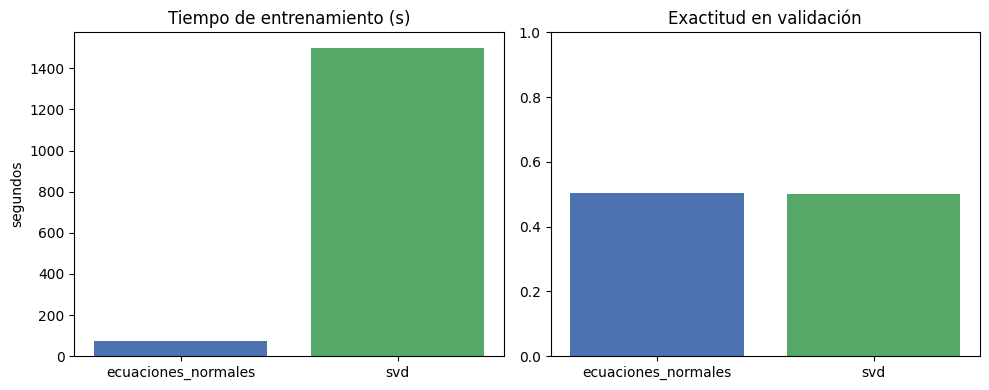

In [15]:
# Mostrar resultados y gráficos de comparación
print('Resultados:')
for metodo, valores in resultados.items():
    print(f"\nMétodo: {metodo}")
    print(f"  tiempo entrenamiento (s): {valores['tiempo_entrenamiento_s']:.4f}")
    print(f"  exactitud train: {valores['exactitud_train']:.4f}")
    print(f"  exactitud val  : {valores['exactitud_val']:.4f}")

if HAY_MPL:
    metodos = list(resultados.keys())
    tiempos = [resultados[m]['tiempo_entrenamiento_s'] for m in metodos]
    exactitudes = [resultados[m]['exactitud_val'] for m in metodos]

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.bar(metodos, tiempos, color=['#4C72B0', '#55A868'])
    plt.title('Tiempo de entrenamiento (s)')
    plt.ylabel('segundos')

    plt.subplot(1,2,2)
    plt.bar(metodos, exactitudes, color=['#4C72B0', '#55A868'])
    plt.title('Exactitud en validación')
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()
else:
    print('\nmatplotlib no disponible: se omiten gráficos.')


## Resolución por descomposición QR (pendiente)

Espacio reservado para implementar entrenamiento y evaluación usando QR.


In [13]:
# TODO: Implementar versión QR
# Sugerencia de firma:
# def train_qr(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
#     ...
pass
